# Compressão JPEG com DCT, Quantização e Codificação Entropia
Este notebook implementa uma versão da compressão JPEG, usando técnicas como DCT, quantização, ordenação zig-zag e codificação de Huffman.

In [78]:

%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from PIL import Image
from heapq import heappush, heappop, heapify
from collections import defaultdict


## Cálculo da Entropia e Histograma

In [79]:

def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()
    return entropy

def showHistogram(img, title='Histograma'):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    plt.plot(hist, color='gray')
    plt.xlabel('Pixels')
    plt.ylabel('Frequencia normalizada')
    plt.title(title)
    plt.show()


## Codificação de Huffman

In [80]:

def encode(symb2freq):
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

def numero_bits(img, huff, height, width):
    nbits = 0
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()

    for i in range(0,256):
        nbits += len(huff[i][1]) * hist[huff[i][0]] * height * width
    return nbits / (height * width)

## Ordenação Zig-Zag

In [81]:

def zigzag(matrix):
    linhas, cols = matrix.shape
    matrix = np.array(matrix)
    resultado = [[] for _ in range(linhas + cols - 1)]
    for i in range(linhas):
        for j in range(cols):
            sum_idx = i + j
            if sum_idx % 2 == 0:
                resultado[sum_idx].insert(0, matrix[i][j])
            else:
                resultado[sum_idx].append(matrix[i][j])
    return [item for lista in resultado for item in lista]

def inverso_zigzag(zigzagged, linhas, cols):
    resultado = np.zeros((linhas, cols))
    index = 0
    for i in range(linhas + cols - 1):
        if i % 2 == 0:
            for j in range(max(0, i - cols + 1), min(i + 1, linhas)):
                resultado[j, i - j] = zigzagged[index]
                index += 1
        else:
            for j in range(max(0, i - cols + 1), min(i + 1, linhas)):
                resultado[i - j, j] = zigzagged[index]
                index += 1
    return resultado


## Transformadas DCT/IDCT e Métricas de Avaliação

In [82]:

def get_2D_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)


## Codificação e Decodificação por Entropia

In [83]:
def entropy_encoding(quantized_blocks, output_file):
    zigzagged = []
    for block in quantized_blocks:
        zigzagged.extend(zigzag(block))

    symb2freq = defaultdict(int)
    for symbol in zigzagged:
        symb2freq[symbol] += 1

    huffman_encoded = encode(symb2freq)
    huffman_dict = {p[0]: p[1] for p in huffman_encoded}

    encoded_data = "".join(huffman_dict[symbol] for symbol in zigzagged)
    
    with open(output_file, "w") as f:
        for symbol, code in huffman_dict.items():
            symbol = int(symbol)
            f.write(f"{symbol}: {code}\n")
        f.write("===\n")
        f.write(encoded_data)

def entropy_decoding(encoded_file, QM, size, step):
    with open(encoded_file, "r") as f:
        lines = f.readlines()
    huffman_dict = {}
    encoded_data = ""
    separator_found = False
    for line in lines:
        if line.strip() == "===":
            separator_found = True
            continue
        if not separator_found:
            symbol, code = line.strip().split(": ")
            huffman_dict[code] = float(symbol)
        else:
            encoded_data += line.strip()
    decoded_symbols = []
    buffer = ""
    for bit in encoded_data:
        buffer += bit
        if buffer in huffman_dict:
            decoded_symbols.append(huffman_dict[buffer])
            buffer = ""
    quantized_blocks = []
    for i in range(0, len(decoded_symbols), step * step):
        block = decoded_symbols[i:i + step * step]
        block = inverso_zigzag(block, step, step)
        quantized_blocks.append(block)
    reconstructed_image = np.zeros(size, dtype=float)
    idx = 0
    for y in range(0, size[0], step):
        for x in range(0, size[1], step):
            block = quantized_blocks[idx]
            block = np.multiply(block, QM)
            reconstructed_image[y:y+step, x:x+step] = get_2d_idct(block)
            idx += 1
    return reconstructed_image + 128


## Compressão JPEG na Imagem Lena

Entropia original: 7.44


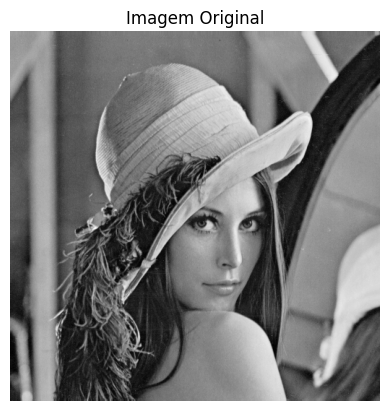

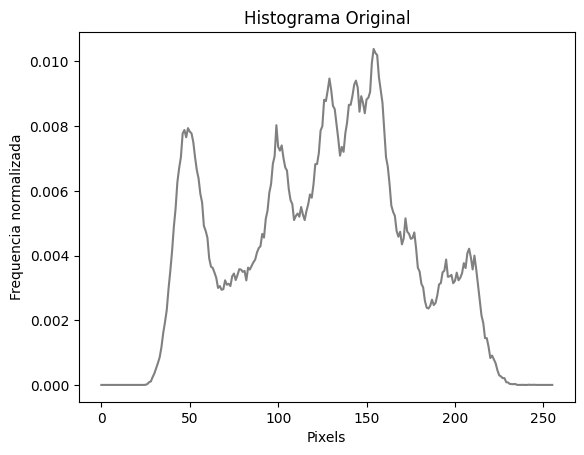

In [84]:
img = cv2.imread('lena512.pgm', 0)
print(f"Entropia original: {calcEntropy(img):.2f}")
plt.imshow(img, cmap="gray")
plt.title("Imagem Original")
plt.axis('off')
plt.show()

showHistogram(img, "Histograma Original")

img = img.astype(float)


Sumário
Entropia: 7.47
size: 47232 bytes
Taxa de Compressão(Com header): 5.55
RMSE: 6.888
PSNR: 31.370 dB


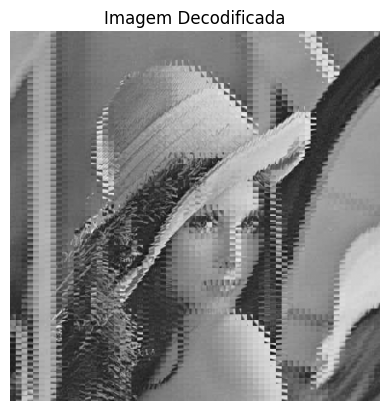

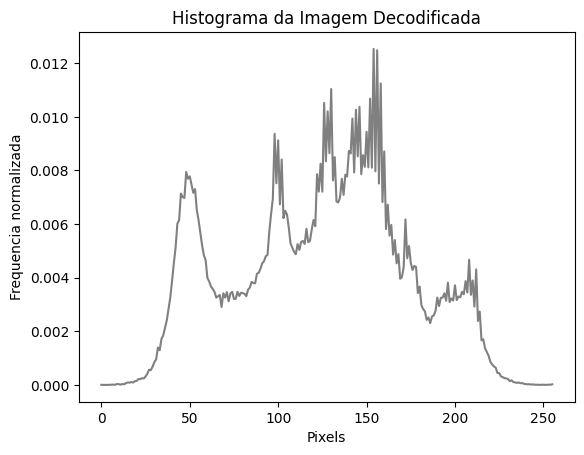

In [88]:
step = 8
size = img.shape
IDCT = np.zeros(size, dtype=float)
DCT = np.zeros(size, dtype=float)

QM = np.matrix([
    [16, 11, 10, 16, 24, 40, 51, 61], 
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
]).astype(float)

dc_coefficients = []
quantized_blocks = []
img_desloc = img - 128

for y in range(0, size[0], step):
    for x in range(0, size[1], step):
        block = img_desloc[y:y+step, x:x+step]
        dct = get_2D_dct(block)
        dc_coefficients.append(dct[0, 0])
        dct = np.divide(dct, QM)
        dct = np.round(dct)
        quantized_blocks.append(dct)

output_file = "encoded_image.txt"
entropy_encoding(quantized_blocks, output_file)
decoded_image = entropy_decoding(output_file, QM, size, step)

img_reconstructed = np.clip(decoded_image, 0, 255).astype(np.uint8)
original_img = np.clip(img, 0, 255).astype(np.uint8)

tamanho_original = img.size * 8  # número de pixels * 8 bits por pixel

# tamanho comprimido total em bits
with open(output_file, "r") as f:
    linhas = f.readlines()
    tamanho_comprimido = sum(len(linha.strip()) for linha in linhas if linha.strip() and linha.strip() != "===")

print("Sumário")
print("Entropia: %.2f" % calcEntropy(img_reconstructed))
print("size: %d bytes" % (tamanho_comprimido/8))
print(f"Taxa de Compressão(Com header): {tamanho_original/tamanho_comprimido:.2f}")
print(f"RMSE: {rmse(original_img, img_reconstructed):.3f}")
print(f"PSNR: {psnr(original_img, img_reconstructed):.3f} dB")

plt.imshow(img_reconstructed, cmap="gray")
plt.title("Imagem Decodificada")
plt.axis('off')
plt.show()

showHistogram(img_reconstructed, "Histograma da Imagem Decodificada")